# Disassembling to t-SNE

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
#Hyperparameters
no_dims=2
initial_dims=50
perplexity=30.0

In [6]:
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
dfX = pd.DataFrame(X)
dfX.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 1. LDR projection in $\mathbb{R}^2$ with PCA

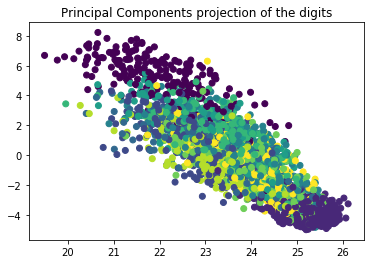

In [9]:
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis,random_projection)
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
(n, d) = X.shape
plt.scatter(X_pca[:,0],X_pca[:,1],c = labels)
plt.title("Principal Components projection of the digits")
plt.show()

In [16]:
max_iter = 1000
initial_momentum = 0.5
final_momentum = 0.8
eta = 500
min_gain = 0.01
Y = np.random.randn(n, no_dims)#standard normal distribution.
dY = np.zeros((n, no_dims))
iY = np.zeros((n, no_dims))
gains = np.ones((n, no_dims))

## 2. Computing the conditional probability 

In [33]:
# Initialize some variables
(n, d) = X.shape
sum_X = np.sum(np.square(X), 1)
D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
P = np.zeros((n, n))
beta = np.ones((n, 1))
logU = np.log(perplexity)
tol=1e-5

In [35]:
D.shape

(2500, 2500)

In [24]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [28]:
for i in range(n):

    # Print progress
    if i % 500 == 0:
        print("Computing P-values for point %d of %d..." % (i, n))
    # Compute the Gaussian kernel and entropy for the current precision
    betamin = -np.inf
    betamax = np.inf
    Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
    (H, thisP) = Hbeta(Di, beta[i])

    # Evaluate whether the perplexity is within tolerance
    Hdiff = H - logU
    tries = 0
    while np.abs(Hdiff) > tol and tries < 50:
        # If not, increase or decrease precision
        if Hdiff > 0:
            betamin = beta[i].copy()
            if betamax == np.inf or betamax == -np.inf:
                beta[i] = beta[i] * 2.
            else:
                beta[i] = (beta[i] + betamax) / 2.
        else:
            betamax = beta[i].copy()
            if betamin == np.inf or betamin == -np.inf:
                beta[i] = beta[i] / 2.
            else:
                beta[i] = (beta[i] + betamin) / 2.

        # Recompute the values
        (H, thisP) = Hbeta(Di, beta[i])
        Hdiff = H - logU
        tries += 1

    # Set the final row of P
    P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
    # Return final P-matrix
print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))


Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.786822


In [32]:
print(pd.DataFrame(P).shape)
pd.DataFrame(P).head()

(2500, 2500)


,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.000000e+00,6.381110e-06,1.902005e-09,4.910938e-06,7.438002e-08,7.853118e-07,2.694145e-05,7.113248e-04,1.399882e-05,6.043804e-07,...,5.021791e-08,1.163161e-06,2.551732e-06,1.818961e-05,3.211258e-09,2.238562e-06,2.168091e-09,6.889318e-07,3.140371e-07,5.302058e-07
1,2.822738e-06,0.000000e+00,1.135894e-09,5.662448e-08,1.677174e-07,1.471385e-06,4.088199e-08,1.184163e-06,7.035890e-08,1.677174e-07,...,2.323007e-07,2.886458e-07,5.079803e-08,3.656445e-03,2.951616e-08,7.035890e-08,5.790270e-09,1.869544e-07,3.290162e-08,1.062317e-06
2,3.113040e-08,7.475821e-09,0.000000e+00,1.245068e-05,1.270433e-06,9.745526e-08,4.586959e-06,5.290265e-06,2.989972e-06,2.115854e-03,...,1.101537e-06,1.988695e-07,1.465225e-06,1.759440e-08,2.293616e-07,2.989972e-06,1.123978e-07,1.948989e-06,1.910076e-05,1.910076e-05
3,1.396689e-13,9.969682e-17,3.015427e-15,0.000000e+00,7.681276e-13,9.120449e-14,5.227678e-12,2.539603e-14,5.448384e-11,2.323276e-11,...,1.889324e-16,2.421362e-10,9.505502e-13,5.047744e-18,1.658374e-14,2.723886e-02,1.340111e-14,2.026420e-04,6.785108e-16,9.505502e-13
4,2.683770e-11,1.044931e-10,1.910555e-11,2.401364e-08,0.000000e+00,8.663654e-09,1.679881e-06,8.027894e-10,1.529626e-05,1.313367e-07,...,5.422934e-04,3.071498e-07,9.187697e-06,1.770354e-12,1.360110e-11,1.709513e-08,1.336534e-09,7.309847e-09,6.773432e-10,1.612006e-11
